## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [ ]:
!pip install mpld3

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    #print(len(pr_errors))
    #print(len(confidence_est))
    
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidences = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidences)
    
    # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def loadTroikaRefFile(ref_fl):
    """
    Loads and extracts signals from a troika ref data file.

    Args:
        ref_fls: (str) filepath to a troika .mat file.

    Returns:
        numpy array for reference values of 8 sec of BPM.
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data

def bandpass_filter(signal, low_f, high_f, fs):
    """
    Runs a bandpath filter on the signal filtering between parameters.
    Args:
        signal: Numpy array to filter
        low_f: low frequency bound
        high_f: high frequency bound
        fs: sample rate
        
    Returns:
        filtered signal
    """ 
    b, a = scipy.signal.butter(3, (low_f, high_f), btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

def featurize(ppg, accx, accy, accz):
    """
    Creates features. Used within a window to analyze the data.

    Args:
        ppg: ppg sensor data. Implied @ 125Hz
        accx: acc x direction sensor data. Implied @ 125Hz
        accy: acc y direction  sensor data. Implied @ 125Hz
        accz: acc z direction  sensor data. Implied @ 125Hz
        
    Returns:
        Set with max ppg frequencey and max acc frequency
        Array of highest powered frequencies to lowest in ppg
        FFT of ppg bandpass filtered
        ppg sensor data with bandpass filter applied
        accx sensor data with bandpass filter applied
        accy sensor data with bandpass filter applied
        accz sensor data with bandpass filter applied
    """ 
    fs = 125
    low_f = 40/60
    high_f = 240/60
    
    ppg = bandpass_filter(ppg, low_f, high_f, fs)
    accx = bandpass_filter(accx, low_f, high_f, fs)
    accy = bandpass_filter(accy, low_f, high_f, fs)
    accz = bandpass_filter(accz, low_f, high_f, fs)
    
    # Fourier Transform and the frequency domain
    n = len(ppg) * 4
    ppg_freqs = np.fft.rfftfreq(n, 1/fs)
    ppg_fft_mag = np.abs(np.fft.rfft(ppg,n))
    ppg_fft_mag[(ppg_freqs <= 40/60.0) & (ppg_freqs >= 240/60.0)] = 0.0

    ppg_mag_peaks = ppg_freqs[np.argsort(ppg_fft_mag)[-4:][::-1]]
    
    # L2-Norms of acc
    #l2_acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
    
    # FFT for acc valules
    accx_fft_mag = np.abs(np.fft.rfft(accx, n))
    accx_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accx_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    accy_fft_mag = np.abs(np.fft.rfft(accy, n))
    accy_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accy_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    accz_fft_mag = np.abs(np.fft.rfft(accy, n))
    accz_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accz_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    
    # max frequency for ppg as a feature
    ppg_feature = ppg_freqs[np.argmax(ppg_fft_mag)]
    # max frequency for L2 norm of acc
    accx_feature = ppg_freqs[np.argmax(accx_fft_mag)]
    accy_feature = ppg_freqs[np.argmax(accy_fft_mag)]
    accz_feature = ppg_freqs[np.argmax(accz_fft_mag)]
    
    return (np.array([ppg_feature, accx_feature, accy_feature, accz_feature]), 
            ppg_freqs, ppg_mag_peaks, ppg_fft_mag, ppg, accx, accy, accz)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Uses the data and reference files, creates BPM estimates and returns errors and confidence.

    Args:
        data_fl: Data file that contains PPG and accelerometer data.
        ref_fl: Data file that contains reference BPM in 8 second windows.
        
    Returns:
        Array of errors for each 8 second window.
        Array of confidence values in each 8 second window.
    """ 

    fs=125
    window_size = 8
    window_shift = 2
    freq_shift_percent = .1
    confidence_window_f = 30 / 60 
    
    #print("Start RunPulseRateAlgorithm:", data_fl, " ", ref_fl)
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ts=np.arange(len(ppg))/fs
    
    ref_bpm=loadTroikaRefFile(ref_fl)
    errors, confidences = [], []
    last_freq = 0
    
    for i in range(len(ref_bpm)): 
        # Determine window to process data
        window_start = i * window_shift
        window_end = window_start + window_size
        #print(window_start)
        #print(window_end)
        w_ts = ts[window_start * fs: window_end * fs]
        w_ppg = ppg[window_start * fs:window_end * fs]
        w_accx = accx[window_start * fs:window_end * fs]
        w_accy = accy[window_start * fs:window_end * fs]
        w_accz = accz[window_start * fs:window_end * fs]

        # Create features to analyze
        w_max_ppg_acc_freq, w_ppg_freqs, w_ppg_mag, w_ppg_fft_mag, w_ppg, w_accx, w_accy, w_accz = featurize(w_ppg, w_accx, w_accy, w_accz)

        #print(w_max_ppg_acc_freq)
        #print(w_ppg_mag)

        # Adjust if one of the accelerometers has same frequency as PPG.
        hb_freq = 0
        if (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[1]) < .01):
            #print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[1])
            hb_freq = w_ppg_mag[1]
        elif (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[2]) < .01):
            #print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[2])
            hb_freq = w_ppg_mag[2]
        elif (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[3]) < .01):
            #print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[3])
            hb_freq = w_ppg_mag[3]
        else:
            hb_freq = w_max_ppg_acc_freq[0]

        #print("i: ", i, "last freq:", last_freq, " this freq:", hb_freq)
        #print(w_ppg_mag)
        
        # Evaluate if new estimate is more than 10% away from previous estimate, if so..
        # Find frequency closest to last frequency to attenuate the error a bit.
        if (last_freq != 0):
            if (np.abs(hb_freq - last_freq) / last_freq > freq_shift_percent):
                #print("adjust to closest freq")
                hb_freq = np.min(w_ppg_mag - last_freq) + last_freq
                #print("Closest: ", np.min(np.abs(w_ppg_mag - last_freq)) + last_freq)

        BPM = hb_freq * 60

        # Deterimine the error
        error = np.abs((ref_bpm[i].item()-BPM))
        #print("i:", i, "ref_val", ref_bpm[i].item(), "BPM: ", BPM, " error:", error)
        errors.append(error)

        last_freq = hb_freq
        
        # Deterime the confidence
        ppg_signal = np.sum(w_ppg_fft_mag[(w_ppg_freqs > hb_freq - confidence_window_f) & (w_ppg_freqs < hb_freq + confidence_window_f)])
        ppg_signal_total = np.sum(w_ppg_fft_mag)
        confidence = ppg_signal / ppg_signal_total

        confidences.append(confidence)

    return errors, confidences

In [2]:
Evaluate()

21.469262632671839

In [63]:
import mpld3
mpld3.enable_notebook()

ModuleNotFoundError: No module named 'mpld3'

Text(0.5,0,'Time(sec)')

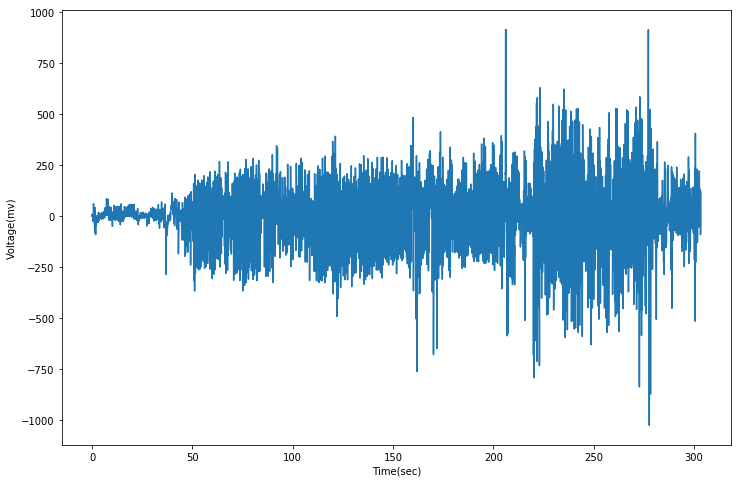

In [5]:
from matplotlib import pyplot as plt

data_fls, ref_fls = LoadTroikaDataset()

ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
l2_acc = l2_acc = np.sqrt(accx**2 + (accy-np.mean(accy))**2 + accz**2)

fs=125
ts=np.arange(len(ppg))/fs
plt.figure(figsize=(12,8))
plt.plot(ts,ppg)
plt.ylabel('Voltage(mv)')
plt.xlabel('Time(sec)')

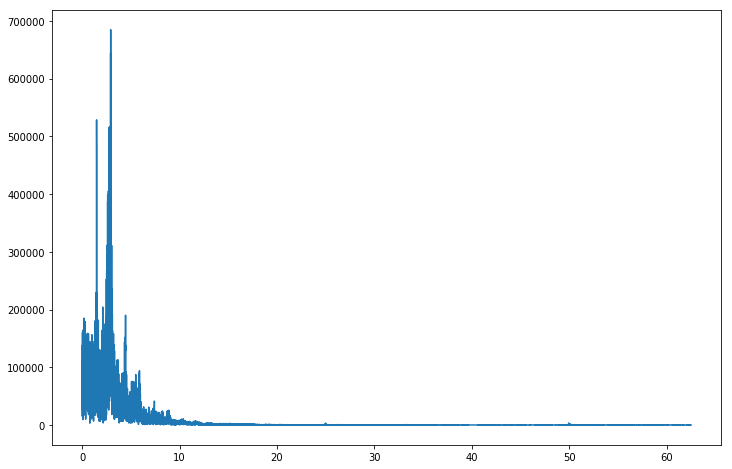

In [6]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft_mag = np.abs(np.fft.rfft(ppg)) 

plt.figure(figsize=(12,8))
plt.plot(freqs,fft_mag)

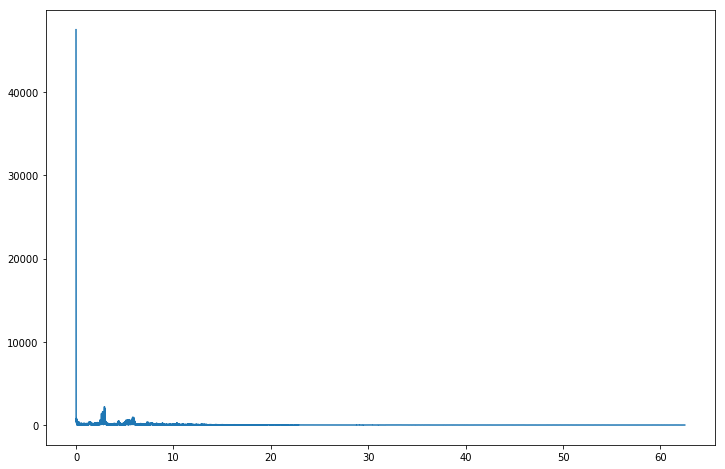

In [7]:
freqs = np.fft.rfftfreq(len(l2_acc), 1/fs)
fft_mag = np.abs(np.fft.rfft(l2_acc)) 

plt.figure(figsize=(12,8))
plt.plot(freqs,fft_mag)

Text(0,0.5,'Frequency (Hz)')

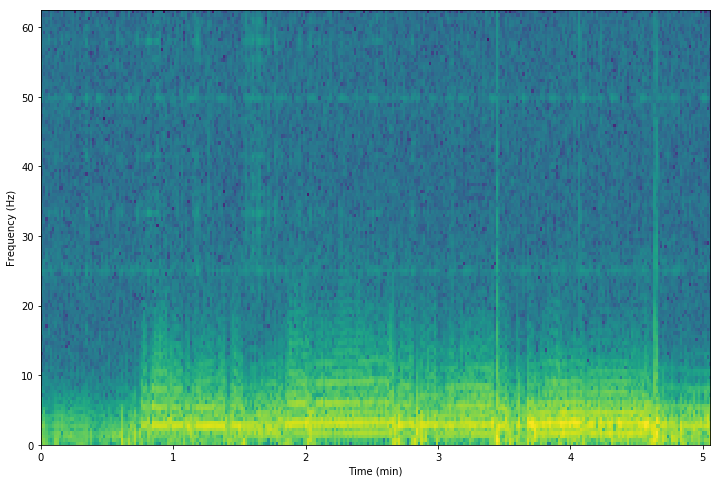

In [8]:
plt.figure(figsize=(12,8))
plt.specgram(ppg, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(ppg) / fs / 60])
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

In [9]:
low_f = 40 / 60 # convert bpm to Hz
high_f = 240 / 60 # convert bpm to Hz

ppg = bandpass_filter(ppg, low_f, high_f)
accx = bandpass_filter(accx, low_f, high_f)
accy = bandpass_filter(accy, low_f, high_f)
accz = bandpass_filter(accz, low_f, high_f)

l2_acc = np.sqrt(accx**2 + (accy-np.mean(accy))**2 + accz**2)

Text(0.5,0,'Time(sec)')

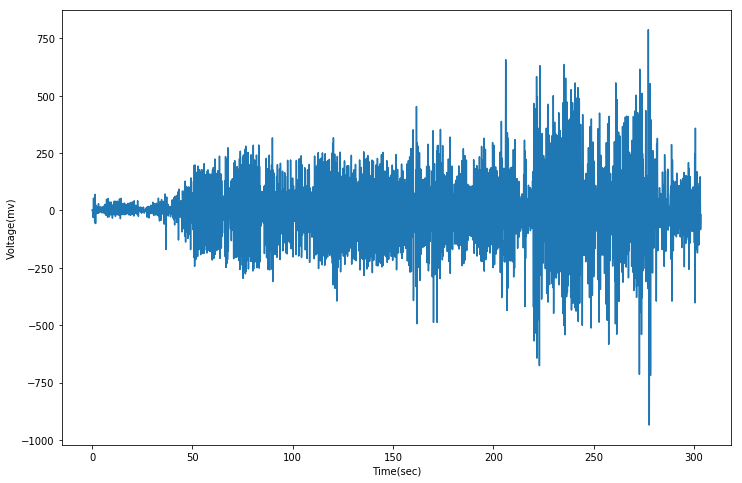

In [10]:
ts=np.arange(len(ppg))/fs
plt.figure(figsize=(12,8))
plt.plot(ts,ppg)
plt.ylabel('Voltage(mv)')
plt.xlabel('Time(sec)')

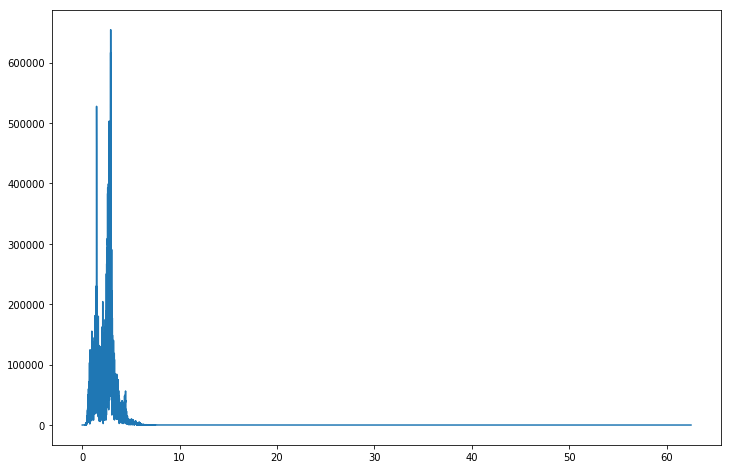

In [11]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft_mag = np.abs(np.fft.rfft(ppg)) 

plt.figure(figsize=(12,8))
plt.plot(freqs,fft_mag)

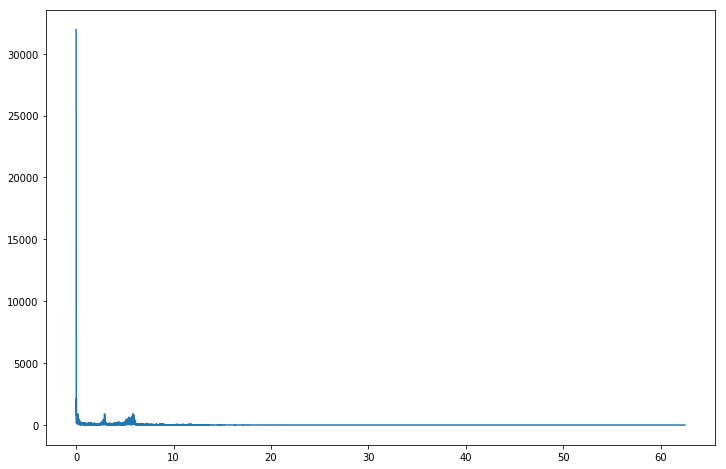

In [12]:
freqs_acc = np.fft.rfftfreq(len(l2_acc), 1/fs)
fft_mag_acc = np.abs(np.fft.rfft(l2_acc)) 

plt.figure(figsize=(12,8))
plt.plot(freqs_acc,fft_mag_acc)

Text(0,0.5,'Frequency (Hz)')

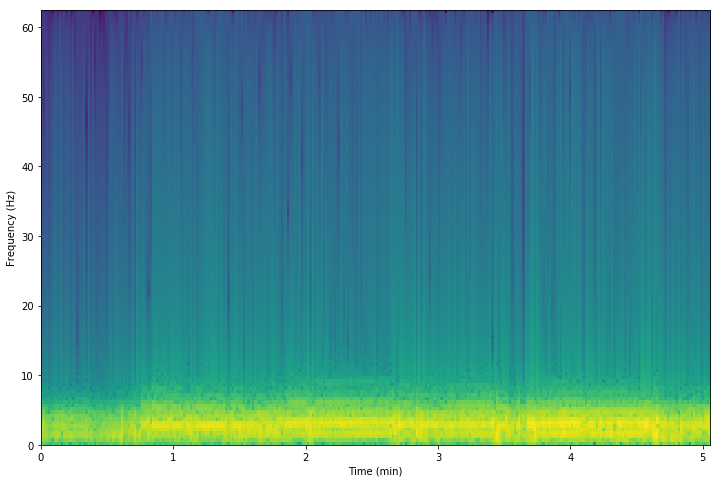

In [13]:
plt.figure(figsize=(12,8))
plt.specgram(ppg, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(ppg) / fs / 60])
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

In [47]:
def loadTroikaRefFile(ref_fl):
    """
    Loads and extracts signals from a troika ref data file.

    Args:
        ref_fls: (str) filepath to a troika .mat file.

    Returns:
        numpy array for reference values of 8 sec of BPM.
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data


def featurize(ppg, accx, accy, accz):
    """
    Creates features. Used within a window to analyze the data.

    Args:
        ppg: ppg sensor data. Implied @ 125Hz
        accx: acc x direction sensor data. Implied @ 125Hz
        accy: acc y direction  sensor data. Implied @ 125Hz
        accz: acc z direction  sensor data. Implied @ 125Hz
        
    Returns:
        Set with max ppg frequencey and max acc frequency
        Array of highest powered frequencies to lowest in ppg
        FFT of ppg bandpass filtered
        ppg sensor data with bandpass filter applied
        accx sensor data with bandpass filter applied
        accy sensor data with bandpass filter applied
        accz sensor data with bandpass filter applied
    """ 
    low_f = 40/60
    high_f = 240/60
    
    ppg = bandpass_filter(ppg, low_f, high_f)
    accx = bandpass_filter(accx, low_f, high_f)
    accy = bandpass_filter(accy, low_f, high_f)
    accz = bandpass_filter(accz, low_f, high_f)
    
    # Fourier Transform and the frequency domain
    fs = 125
    n = len(ppg) * 4
    ppg_freqs = np.fft.rfftfreq(n, 1/fs)
    ppg_fft_mag = np.abs(np.fft.rfft(ppg,n))
    ppg_fft_mag[(ppg_freqs <= 40/60.0) & (ppg_freqs >= 240/60.0)] = 0.0

    ppg_mag_peaks = ppg_freqs[np.argsort(ppg_fft_mag)[-4:][::-1]]
    
    # L2-Norms of acc
    #l2_acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
    
    # FFT for acc valules
    accx_fft_mag = np.abs(np.fft.rfft(accx, n))
    accx_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accx_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    accy_fft_mag = np.abs(np.fft.rfft(accy, n))
    accy_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accy_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    accz_fft_mag = np.abs(np.fft.rfft(accy, n))
    accz_fft_mag[ppg_freqs <= 40/60.0] = 0.0
    accz_fft_mag[ppg_freqs >= 240/60.0] = 0.0
    
    # max frequency for ppg as a feature
    ppg_feature = ppg_freqs[np.argmax(ppg_fft_mag)]
    # max frequency for L2 norm of acc
    accx_feature = ppg_freqs[np.argmax(accx_fft_mag)]
    accy_feature = ppg_freqs[np.argmax(accy_fft_mag)]
    accz_feature = ppg_freqs[np.argmax(accz_fft_mag)]
    
    return (np.array([ppg_feature, accx_feature, accy_feature, accz_feature]), 
            ppg_freqs, ppg_mag_peaks, ppg_fft_mag, ppg, accx, accy, accz)

In [49]:
def TestRunPulseRateAlgorithm():

    file_no = 0

    ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[file_no])
    ref_bpm=loadTroikaRefFile(ref_fls[file_no])

    window_size = 8
    #i = 20
    errors, confidences = [], []
    last_freq = 0

    #for i in range(round((ppg.shape[0] / fs - 8) / 2)): 
    for i in range(len(ref_bpm)): 
        window_start = i * 2
        window_end = window_start + window_size

        #print(window_start)
        #print(window_end)

        w_ts = ts[window_start * fs: window_end * fs]
        #print(len(ts))
        #print(len(w_ppg))
        w_ppg = ppg[window_start * fs:window_end * fs]
        w_accx = accx[window_start * fs:window_end * fs]
        w_accy = accy[window_start * fs:window_end * fs]
        w_accz = accz[window_start * fs:window_end * fs]

        w_max_ppg_acc_freq, w_ppg_freqs, w_ppg_mag, w_ppg_fft_mag, w_ppg, w_accx, w_accy, w_accz = featurize(w_ppg, w_accx, w_accy, w_accz)

        #print(w_max_ppg_acc_freq)
        #print(w_ppg_mag)

        hb_freq = 0
        if (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[1]) < .01):
            print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[1])
            hb_freq = w_ppg_mag[1]
        elif (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[2]) < .01):
            print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[2])
            hb_freq = w_ppg_mag[2]
        elif (abs(w_max_ppg_acc_freq[0] - w_max_ppg_acc_freq[3]) < .01):
            print("AccX same as PPG. Orig: ", w_max_ppg_acc_freq[0], " New: ", w_ppg_mag[3])
            hb_freq = w_ppg_mag[3]
        else:
            hb_freq = w_max_ppg_acc_freq[0]

        BPM = hb_freq * 60

        #print(BPM)
        #print(ref_bpm[i].item())

        error = np.abs((ref_bpm[i].item()-BPM))
        print("i:", i, "ref_val", ref_bpm[i].item(), "BPM: ", BPM, " error:", error)
        errors.append(error)

        print("last freq:", last_freq, " this freq:", hb_freq)
        print(w_ppg_mag)
        closest_freq = np.min(np.abs(w_ppg_mag - last_freq)) + last_freq
        if (np.abs(hb_freq - last_freq) / last_freq > .3):
            print("adjust to closest freq")
            hb_freq = closest_freq
        print("Closest: ", closest_freq)
        last_freq = hb_freq
        
        window_f = 30 / 60 # within 15 BPM of primary peak 
        ppg_signal = np.sum(w_ppg_fft_mag[(w_ppg_freqs > hb_freq - window_f) & (w_ppg_freqs < hb_freq + window_f)])
        ppg_signal_total = np.sum(w_ppg_fft_mag)
        confidence = ppg_signal / ppg_signal_total

        #print("Confidence Data")
        #print(ppg_signal)
        #print(total_signal)
        #print(confidence)
        confidences.append(confidence)

    return errors, confidences

errors, confidences = TestRunPulseRateAlgorithm()

i: 0 ref_val 74.33920704845815 BPM:  73.125  error: 1.21420704846
last freq: 0  this freq: 1.21875
[ 1.21875  1.25     2.4375   2.46875]
adjust to closest freq
Closest:  1.21875
i: 1 ref_val 76.35746606334841 BPM:  75.0  error: 1.35746606335
last freq: 1.21875  this freq: 1.25
[ 1.25     1.28125  1.21875  1.3125 ]
Closest:  1.21875
i: 2 ref_val 77.14285714285714 BPM:  76.875  error: 0.267857142857
last freq: 1.25  this freq: 1.28125
[ 1.28125  1.3125   1.25     1.34375]
Closest:  1.25
i: 3 ref_val 74.66814159292035 BPM:  75.0  error: 0.33185840708
last freq: 1.28125  this freq: 1.25
[ 1.25     1.28125  1.21875  1.3125 ]
Closest:  1.28125
i: 4 ref_val 72.58064516129032 BPM:  71.25  error: 1.33064516129
last freq: 1.25  this freq: 1.1875
[ 1.1875   1.21875  1.15625  1.25   ]
Closest:  1.25
i: 5 ref_val 71.68458781362007 BPM:  71.25  error: 0.43458781362
last freq: 1.1875  this freq: 1.1875
[ 1.1875   1.21875  1.15625  1.25   ]
Closest:  1.1875
i: 6 ref_val 72.89416846652267 BPM:  73.125 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars



Closest:  2.65625
i: 44 ref_val 117.05685618729098 BPM:  151.875  error: 34.8181438127
last freq: 2.53125  this freq: 2.53125
[ 2.53125  2.5625   2.5      2.75   ]
Closest:  2.53125
i: 45 ref_val 118.54583772391992 BPM:  166.875  error: 48.3291622761
last freq: 2.53125  this freq: 2.78125
[ 2.78125  2.75     2.       1.96875]
Closest:  2.75
AccX same as PPG. Orig:  2.71875  New:  2.0
i: 46 ref_val 120.1923076923077 BPM:  120.0  error: 0.192307692308
last freq: 2.78125  this freq: 2.0
[ 2.71875  2.75     2.       2.6875 ]
Closest:  2.8125
AccX same as PPG. Orig:  2.75  New:  2.78125
i: 47 ref_val 121.8851570964247 BPM:  166.875  error: 44.9898429036
last freq: 2.0  this freq: 2.78125
[ 2.75     2.78125  2.03125  2.     ]
adjust to closest freq
Closest:  2.0
i: 48 ref_val 123.96694214876034 BPM:  123.75  error: 0.21694214876
last freq: 2.0  this freq: 2.0625
[ 2.0625   2.03125  2.78125  2.75   ]
Closest:  2.03125
i: 49 ref_val 125.78616352201259 BPM:  125.625  error: 0.161163522013
last

NameError: name 'w_l2_acc' is not defined

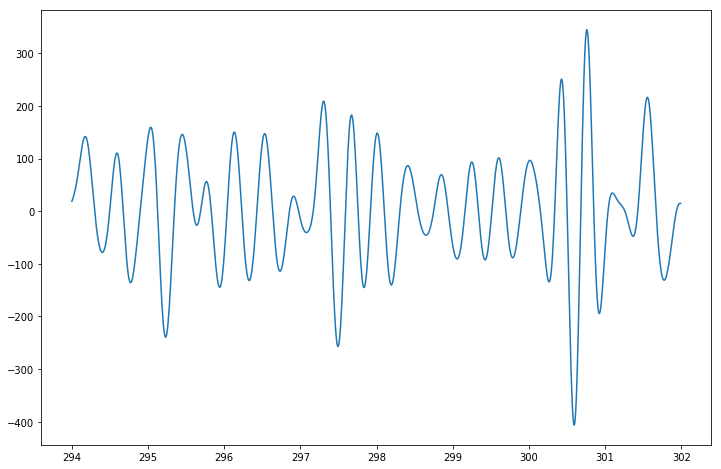

In [34]:
plt.figure(figsize=(12,8))
plt.plot(w_ts,w_ppg)
plt.plot(w_ts,w_l2_acc)
plt.ylabel('Voltage(mv)')
plt.xlabel('Time(sec)')

In [ ]:
pks = sp.signal.find_peaks(w_ppg, distance=1)[0]
plt.plot(w_ppg)
plt.plot(pks, w_ppg[pks], 'r.', ms=10)

In [ ]:
freqs = np.fft.rfftfreq(len(w_ppg), 1/fs)
fft_mag = np.abs(np.fft.rfft(w_ppg)) 

plt.figure(figsize=(12,8))
plt.plot(freqs,fft_mag)

In [ ]:
freqs_acc = np.fft.rfftfreq(len(l2_acc), 1/fs)
fft_mag_acc = np.abs(np.fft.rfft(l2_acc)) 

plt.figure(figsize=(12,8))
plt.plot(freqs_acc,fft_mag_acc)

In [ ]:
# max frequency for ppg as a feature
ppg_feature = freqs[np.argmax(fft_mag)]
# max frequency for L2 norm of acc
acc_feature = freqs[np.argmax(fft_mag_acc)]

print(ppg_feature)
print(acc_feature)

In [ ]:
plt.figure(figsize=(12,8))
plt.specgram(w_ppg, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(w_ppg) / fs / 60])
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

In [ ]:
bpm_estimate = ppg_feature * 60
print(bpm_estimate)


In [ ]:
rf0=LoadTroikaRefFile(ref_fls[0])

In [ ]:
plt.plot(rf0)
#print(len(rf0))
#print(rf0)
#print(rf0)

print(rf0)
print(rf0[0])
print(len(rf0))

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

**Code Description**

The code includes starter code to read from the Troika dataset a test set of data as well as reference data. The function to trigger the execution of the algorithm and evaluate it's effectiveness is: Evaluate().

Evaluate() uses the LoadTroikaDataset() to retrieve the data and reference filenames of the data to be processed. It then iterates across the data and reference files calling RunPulseRateAlgorithm for each set and aggregating errors and confidences for each set of files. Evaluate then concludes calling AggregateErrorMetrics to evaluate the error and confidence data collected to determine the BPM error rate over the 90% confidence estimates.

RunPulseRateAlgorithm() is the heart of the code for evaluating the BPN in 8 second windows that slide 2 seconds each evaluate. A description of the algorithm itself is below in the Algorithm Description section.  What is important to note from a code perspective is that RunPulseRateAlgorithm() uses loadTroikaRefFile() to load the reference BPM data recorded every 2 seconds across an 8 second window. RunPulseRateAlgorithm() then takes the data file a breaks it into 8 second windows where it calls featurize() in order to determine the features for evaluation of the algorithm. Each 8 second window will result in a BPM estimate that is compared against the reference data to determine the error. The confidence is the percentage of energy in the frequency used to evaluate the BPM divided by the whole frequency spectrum as a way of estimating confidence that the BPM is the highest energy signal in the data.

Once RunPuleRateAlgorithm() evalautes all the 8 second windows it returns error and confidence arrays to Evaluate() when the aggregates the results and loads new file to RunPulseRateAlgorithm() until all files are processed.

**Data Description**

The algorithm is designed to work on the Troika data set referenced above and noted here as well. The troika dataset includes two data files for each subject, the data file and a reference file. The data file contains 4 arrays of sensor data: one PPG sensor recording and 3 accelermometers (x, y, z axis). The sensors are recording at 8Hz or 125ms time frames. These are extracted in each file. The reference data file contains BPM recordings for 8 second windows recorded every 2 second. Each pair of files represents one test subject starting from rest and starting to run at 15km/hr. This shows BPM starting at resting rate and raising to a high activity rate.

There are a few limitations with the data that make it difficult to generalize. First, with only 12 test subjects and no demongraphics data it is unclear if this would generalize to different genders and different ages of individuals. We do know through other medical research that BPM varies siginficantly in individuals based on gender/age so it could be that this test set limits the applicability of any designed algorithm. Additionally the algorithm is only testing an increase in activity and BPM prediction. The data does not have data for returning base to a resting heart rate and the algorithm designed below may not perform well as activity decreases.

Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

**Algorithm Description**

The algorithm is designed to be execuited within the RunPulseRateAlgorithm() method. Within this method the data is broken down into 8 second windows for processing with the algorithm. The algorithm then uses the featurize() method to determine the important data points for evaluate.

Within featurize several processing steps occur. First a low frequency bandpass filter is applied to remove signals below .66Hz and above 4Hz. As we are trying to find the peak associated with heartrate and we know the heartrate should not normally be below 40 BPM and above 240 BPM those frequencies are removed. Next we take the PPG, and all 3 accelerometer signals and create FFT to analyze in the frequency domain. From there, the method identifies the highest frequency signal in PPG, Acc_X, Acc_Y, and Acc_Z to return for evaluation. Additionally the top 4 PPG frequencies are returned along with the bandpass filtered ppg, Acc_X, Acc_Y, and Acc_Z signals. 

Next the algorithm attempts to identify the right frequency for the heartbeat. The initial candidate is the top PPG frequency unless it is the same as one of the accelerometer high frequencies in which case we select the second highest PPG signal. This step helps eliminate accelerometer noise in the overall signal. The second step is attempting to reduce a large swing in frequency between successive windows (which have 6 seconds of overlap). For this the last frequency is compared to the canddidate current frequency. If the new signal is greater than 10% differnce.. then we attempt to find the signal within the top 4 PPG signals that is closes to the last_frequency and use that instead. This attempts to reduce a sudden change in freqencies between windows.

One a frequency is selected, it is covered into a BPM rating and compared to the reference value to determine the error. Lastly for the confidence, we take the energy within .5 Hz and consider it part of the confidence and divide it by the overall energy. The .5Hz was found through trial and error of attempting to create reliable confidence ranges.

Finally the error and confidences are returned from RunPulseRateAlgorithm()

**Algorithm Performance**

Performance was computed by using the TROIKA reference data. The confidence of an estimate was determined as a percentage of the core frequency plus a small range around it relative to total signal energy. This confidence estimate was built with the presumption that the heart signal would be the strongest in the data. The performance of the algorithm attempts to remove accelerometer signal noise by not relying on the PPG top frequency if it is the same as the highest accelerometer rating. The algorithm performance is also based on assumping heartbeat patterns are stable for 8 second intervals and that there are cases where the PPG signal may be occuring faster than the heartbeat. To address these issues as noted in the algorithm description removal of the accelerometer conflicting frequency and attempting to align the frequency closer to the previous window frequency when there is a large frequency jump is done to create better performance. The other factors that play into algorithm performance are the number of top PPG signals to leverage in the case of the last frequency signficantly different than new frequency issue as well as determining when the accelerometer signal is considered the "same" as the PPG signal. Lastly the evaluation of the confidence metric and the range of energy to collect for the confidence is tunable as well. Leveraging all these values allowed for by-hand tuning below 15BPM on the Test (unknown) data set.

Given the caveats in the Data Description section it is hard to consider this a truely generalize algorithm. It is a useful algorithm for stress test type situations where someone is evaluating from resting heart rate to a high activity rate. However as a general use algorithm night and day, the data the algorithm was designed against does not lend to that open ended use. Further data, error analysis and confidence evaluation would be required for that general algorithm. However this algorithm could be the foundation of the generalized version. 

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 